# Análise de tweets: um estudo de caso sobre violência


**IFES - Pós graduação *lato sensu* de Ciência de Dados com Big Data** | Aluno: Nelson

A intenção desta análise é exemplificar um método descritivo-exploratório para o estudo de dados coletados de redes sociais, em específico do Twitter, a partir das bibliotecas *numpy, pandas e networkx*, ou softwares como o [Gephi](https://gephi.org/), que corrobore com pesquisas e investigações de fenômenos sociais.

Uma base de dados de 114 mil tweets em português com o termo de pesquisa **"violência"** foi coletada na semana de 09 a 15 de dezembro de 2018.

- **Contextualização do Tema**:

A violência no Brasil é um problema que atinge a população em níveis maiores que as médias registradas mundialmente. Em 2016, pela primeira vez, o país alcançou a marca de 62.517 homicídio ao ano, o equivalente a uma taxa de 30,3 mortes para cada 100 mil habitantes; isso significa que, em três semanas, são assassinadas no Brasil mais pessoas que o total de mortes em todos os ataques terroristas do mundo nos cinco primeiros meses de 2017 ([G1](http://g1.globo.com/politica/noticia/taxa-de-homicidios-no-brasil-aumenta-mais-de-10-de-2005-a-2015.ghtml)). Observa-se, no entanto, que há diferenças entre os índices de criminalidade dentro do país. Enquanto em Santa Catarina a taxa de homicídios registrada em 2010 foi de 12,9 mortes por 100 mil habitantes, em Alagoas esse índice foi de 66,8 homicídios ([O Globo](https://web.archive.org/web/20111215044451/http://oglobo.globo.com/infograficos/taxa-de-homicidio-estados/)).
 
- **Descrição do Problema**:

Indo numa outra direção, em vez de utilizar múltiplas variáveis de natureza sociológica para arranhar uma real compreensão aprofundada do problema por uma abordagem matemática, pretende-se aqui responder a seguinte pergunta: **como as redes sociais podem contribuir para a compreensão e o estudo de problemas e fenômenos sociais?** Ou ainda, como utilizar as bibliotecas supracitadas (código aberto) para atingir este objetivo?:

- **Motivação/ Justificativa**:

As redes sociais são, em si, representativas das novas tecnologias de informação e comunicação (NTICs), de estrutura descentralizada e rizomática, e permitem uma expressão de alcance e extensão muito maiores que as redes centralizadas e hierárquicas anteriormente dominantes na era analógica.

Como fonte de dados, as redes sociais aparece como uma possibilidade para estudos de correlação entre variáveis psicossociológicas (entre emoções e comportamento político, por exemplo), e a Análise de Redes Sociais (Social Network Analysis) uma interpelação da Sociologia e da Ciência de Dados que se desenvolveu no meio acadêmico em vias recentes - o que contribuiu também para o interesse nesse objeto de pesquisa.

- **Proposta, Objetivos e Limitações**:

A proposta é exemplificar um método descritivo-exploratório para o estudo de dados coletados das redes sociais, em específico do Twitter.

O objetivo principal é demonstrar a viabilidade deste método para adquirir mais informações em torno de um fenômeno social a fim de explorá-lo de diferentes maneiras, numa técnica que não subordine a análise, mas complemente-a - como a partir da teoria dos grafos, demonstrado a seguir.

A limitação principal é trabalhar com um conjunto de dados que, por referir-se a um período de coleta de uma semana, predeterminado pelas capacidades da API gratuita do Twitter, certamente poderia ser expandido a fim de comportar mais dados e uma maior variabilidade a respeito do problema estudado; a fim de evitar-se este problema, um período de coleta maior pode ser contabilizado. Por enquanto, bastou como exemplo.

- **Há trabalhos correlatos? De outra forma, há trabalhos que já fazem o que o seu sistema fará?**

Já me deparei com algumas plataformas pagas que ofereciam análises deste tipo, mas automatizadas, como o [Flocker](http://flocker.outliers.es), uma plataforma da Outliers Collective que permitia a coleta e visualização em tempo real de tweets por meio do navegador, mas que hoje aparenta estar offline ([vídeo](https://www.youtube.com/watch?v=Lbm0uKCdh3U) dele).

- **Base de dados (descrição da base coletada - raw):**

Os dados dos tweets foram retornados Search API do Twitter em modo "extended" ([data sample](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html)). 
Para a coleta de dados, utilizou-se a biblioteca [Twython](https://twython.readthedocs.io/en/latest/api.html) por meio do script [twitter-capture](https://github.com/labic/twitter-capture) (de minha autoria!). Alguns campos retornados foram ignorados na hora de escrever o arquivo CSV final.

Ao todo, 114 mil tweets em português com o termo de pesquisa **"violência"** em seu texto foram coletados, referentes ao período de uma semana entre 09 e 15 de dezembro de 2018 (por limitação inerente à API do Twitter), e o arquivo final pode ser baixado executando-se o comando abaixo:

In [1]:
#!curl -L -o tweets.csv "https://www.dropbox.com/s/mz5os5w8vtet7zw/tweets.csv?dl=1"

Um gazetteer do **GeoNames** contendo os nomes das principais cidades e capitais no Brasil e suas coordenadas geográficas foi utilizado para cruzar os dados de local da publicação retornados do Twitter, que continham o nome da cidade de origem, mas não sua latitude e longitude. Este pode ser baixado e extraído executando-se o comando abaixo, e bases de dados para outras localizações também estão disponíveis [no site](http://download.geonames.org/export/dump/):

In [2]:
#!curl -o BR.zip "http://download.geonames.org/export/dump/BR.zip"
#!unzip BR.zip

A biblioteca **stopwords** do nltk foi utilizada para descartar palavras comuns ou sem significado aparente e pode ser obtida executando:

In [3]:
# import nltk
# nltk.download('stopwords')

**Início da análise:**

In [4]:
# importa funções necessárias
import numpy as np
import pandas as pd
import string
from collections import defaultdict
from csv import reader, writer, QUOTE_MINIMAL
from datetime import datetime
from itertools import combinations
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from nltk.corpus import stopwords
from re import findall
stopwords = stopwords.words('portuguese')
%matplotlib inline

In [5]:
# função para inspecionar o data frame

def check_df_nulls(df, verbose=False):
   
    # get columns with float64 values
    is_float = []
    for i in df.dtypes.keys():
        if df.dtypes[i] == 'float64':
            is_float.append(i)

    # get columns with null values      
    has_null = df.isnull().any()
    for i in has_null.keys():
        if has_null[i]:
            print(i, '=>', df[i].isnull().sum(), 'nulls')\
            if verbose else None
        else: has_null.pop(i)

    # get columns with null float64 values
    to_fill = [value for value in is_float if value in has_null.keys()]

    # print overview
    print(len(df.keys()), 'total columns')
    print(len(is_float), 'are float64')
    print(len(has_null), 'contain nulls')
    print(len(to_fill), 'columns to fill\n')
    # return to_fill

In [6]:
# função para exportar rede em formato gdf

def export_gdf(filename, network=[], header_nodes=[], header_edges=[], directed=True):
    header_nodes = ['nodedef>name VARCHAR'] + header_nodes
    header_edges = ['edgedef>node1 VARCHAR', 'node2 VARCHAR'] + header_edges
    header_edges.append('directed BOOLEAN')
    with open(filename, 'w', newline='', encoding='utf8') as graphfile:
        file_writer = writer(graphfile, delimiter=',')
        file_writer.writerow(header_nodes)
        file_writer.writerow(header_edges)
        for line in network:
            row = list(line)
            row.append(directed)
            file_writer.writerow(row)

In [7]:
# função para verificar se string é número

def is_number(str):
    try:
        int(str)
        return True
    except Exception:
        try:
            float(str)
            return True
        except Exception:
            return False

In [8]:
# função para iterar combinações de uma lista

def list_combinations(list_of_values):
    list_of_combinations = []
    for item in combinations(list_of_values, 2):
        list_of_combinations.append([item[0], item[1]])
    return list_of_combinations

In [9]:
# função para carregar atributos do geonames

def load_geonames(filename):
    geonames = defaultdict(dict)
    with open(filename, 'rt', encoding='utf8') as csvfile:
        csvfile = reader(csvfile, delimiter='\t')
        for line in csvfile:
            geoname_id = line[0]
            name = line[1].lower()
            latitude = str(line[4])
            longitude = str(line[5])
            country_code = line[8]
            geonames[country_code][name] = (latitude, longitude, geoname_id)
    return geonames

In [10]:
# sets e dicionários para substituição de acentos

VALID_CHARACTERS_SET = set([])

EXTRA_CHARACTERS = "_-"
VALID_CHARACTERS = string.ascii_letters + string.digits
VALID_CHARACTERS = VALID_CHARACTERS + EXTRA_CHARACTERS

for character in VALID_CHARACTERS:
    VALID_CHARACTERS_SET.add(character)

ACCENT_REPLACEMENTS = {
    ord('á'):'a', ord('ã'):'a', ord('â'):'a',
    ord('à'):'a', ord('è'):'e', ord('ê'):'e',
    ord('é'):'e', ord('í'):'i', ord('ì'):'i',
    ord('ñ'):'n', ord('ò'):'o', ord('ó'):'o',
    ord('ô'):'o', ord('õ'):'o', ord('ù'):'u',
    ord('ú'):'u', ord('ü'):'u', ord('ç'):'c'}

UNDESIRED_CHARACTERS = set(string.punctuation)

UNDESIRED_CHARACTERS.add('”')
UNDESIRED_CHARACTERS.add('“')
UNDESIRED_CHARACTERS.add('‘')
UNDESIRED_CHARACTERS.add('…')
UNDESIRED_CHARACTERS.add('—')
UNDESIRED_CHARACTERS.add('|')

UNDESIRED_CHARACTERS_SPECIAL = UNDESIRED_CHARACTERS.copy()
UNDESIRED_CHARACTERS_SPECIAL.remove('_')

intab = ''.join(c for c in UNDESIRED_CHARACTERS)
outtab = ''.join(' ' for c in UNDESIRED_CHARACTERS)
punct_translate_tab = str.maketrans(intab, outtab)

In [11]:
# taxa de homicídios a cada 100 mil habitantes por estado brasileiro (2010)
# para exportar para um mapa (cloroplético) mas acabei não utilizando no final
# fonte: https://web.archive.org/web/20111215044451/http://oglobo.globo.com/infograficos/taxa-de-homicidio-estados/

dict_br = {
'Alagoas': 66.8,
'Espírito Santo': 50.1,
'Pará': 45.9,
'Pernambuco': 38.8,
'Amapá': 38.7,
'Paraíba': 38.6,
'Bahia': 37.7,
'Rondônia': 34.7,
'Paraná': 34.4,
'Distrito Federal': 34.2,
'Sergipe': 33.3,
'Mato Grosso': 31.7,
'Amazonas': 30.6,
'Ceará': 29.7,
'Goiás': 29.4,
'Roraima': 27.3,
'Rio de Janeiro': 26.2,
'Mato Grosso do Sul': 25.8,
'Rio Grande do Norte': 22.9,
'Tocantins': 22.5,
'Maranhão': 22.5,
'Acre': 19.6,
'Rio Grande do Sul': 19.3,
'Minas Gerais': 18.1,
'São Paulo': 13.9,
'Piauí': 13.7,
'Santa Catarina': 12.9}

In [12]:
# carrega dataframe
tweets = pd.read_csv('tweets.csv', index_col='id', sep='|', quotechar='"', quoting=QUOTE_MINIMAL, low_memory=False)

In [13]:
# carrega geonames dump
geonames = load_geonames('BR.txt')

In [14]:
# seleciona alguns valores para soma e cálculo de média/mediana e desvio padrão

df = tweets
values = ['rt_count', 'favorite_count', 'user_followers', 'user_following']
types = df.type.unique()

describe = df[values].describe() # .to_dict()

# for v in describe.keys():
#     describe[v]['median'] = df[v].median()
    
# describe = pd.DataFrame.from_dict(describe)

print('\ntype\t\tcount')
for t in list(types):
    print(t, '  \t', len(df[df['type'] == t]))

describe


type		count
Tweet   	 8785
Retweet   	 95345
Quote   	 1520
Reply   	 9149


,rt_count,favorite_count,user_followers,user_following
count,114799.000000,114799.000000,1.147990e+05,114799.000000
mean,3574.648168,3.388235,4.315073e+03,1054.818038
std,4040.137185,168.659456,8.963428e+04,3123.154158
min,0.000000,0.000000,0.000000e+00,0.000000
25%,36.000000,0.000000,1.210000e+02,180.000000
50%,1817.000000,0.000000,3.630000e+02,397.000000
75%,6946.000000,0.000000,1.050000e+03,947.000000
max,45711.000000,20922.000000,1.163375e+07,250249.000000


In [15]:
# limpa a 'cauda' e a 'cabeça' do dataset
# com base no número de retweets recebidos

df = df[df['rt_count'] > 36] # <-- 25%
df = df[df['rt_count'] < 6946] # <--- 75%

df.shape

(55890, 56)

In [16]:
# verifica localizações e adiciona numa lista
# para isso, utiliza todos os tweets coletados
# por conta da baixa frequência de localizações
# anexadas a tweets, e procura por geocoordenadas
# no dataset disponibilizado pelo GeoNames

locations = []
counter_point = 0
counter_geomatch = 0

for line in tweets.values:
    
    geo_type = line[7]
    place = line[15]
    
    if geo_type == 'Point':
        lat = line[8]
        long = line[9]
        locations.append([geo_type, lat, long])
        counter_point += 1
    
    elif isinstance(place, str):
        city = place.split(',')[0].lower()
        country = line[16]
        country_code = line[17]
        
        if country_code in geonames.keys()\
        and city in geonames[country_code].keys():
            latitude = geonames[country_code][city][0]
            longitude = geonames[country_code][city][1]
            geo_type = geonames[country_code][city][2]
            locations.append([geo_type, lat, long])
            counter_geomatch += 1

print('Point locations from Twitter:', counter_point,
      '\nApproximate locations from GeoNames:', counter_geomatch)

Point locations from Twitter: 39 
Approximate locations from GeoNames: 744


In [17]:
# verifica top hashtags, datas, usuários, URLs e palavras
# e adiciona as linhas de tweets com interação entre usuários
# para uma lista com as informações sobre a rede analisada

time_format = '%d/%m/%Y'

network_hts = []
network_rts = []

dict_tweets = {}
dict_dates = defaultdict(int)
dict_hashtags = defaultdict(int)
dict_mentions = defaultdict(int)
dict_names = defaultdict(int)
dict_urls = defaultdict(int)
dict_words = defaultdict(int)

dict_dates_by_type = defaultdict(lambda:defaultdict(int))

for line in df.values:
    
    timestamp = line[11]
    tdate = datetime.utcfromtimestamp(timestamp)
    tdate = tdate.strftime(time_format) # <-- convert to daily string
    tdate = datetime.strptime(tdate, time_format)
    ttype = line[12].lower()
    rt_count = line[13]
    
    hashtags = set()
    mentions = set()
    names = set()
    urls = set()
    words = set()
    
    dict_dates[tdate] += 1
    dict_dates_by_type[ttype][tdate] += 1
    
    text = str(line[0]).replace(',','')\
                       .replace('\'','')\
                       .replace('"','')\
                       .replace('\n','')\
                       .replace('\r','')

    dict_tweets[text] = rt_count
    
    for word in text.split():
        
        is_hashtag = word.startswith('#')
        
        if word.startswith('http'):
            urls.add(word)
        
        elif word.startswith('@'):
            mention = findall(r'(?<=@)[a-zA-Z0-9_]+', word)
            mentions.add(mention[0])\
                if len(mention) == 1 else None
        
        else: # common word
            str_word = word.lower()
            str_word = str_word.translate(ACCENT_REPLACEMENTS)
            str_word = ''.join(character for character in str_word if character not in UNDESIRED_CHARACTERS)
            if len(str_word)>2\
            and not is_number(str_word)\
            and str_word not in stopwords:
                if is_hashtag:
                    hashtags.add('#'+str_word)
                elif word == word.capitalize():
                    names.add(str_word.capitalize())
                else: words.add(str_word)
    
    for h in hashtags:
        dict_hashtags[h] += 1
    for m in mentions:
        dict_mentions[m] += 1
    for n in names:
        dict_names[n] += 1
    for u in urls:
        dict_mentions[u] += 1
    for w in words:
        dict_words[w] += 1
    
    if len(hashtags) > 1:
        for combination in list_combinations(hashtags):
            source = combination[0]
            target = combination[1]
            network_hts.append([source, target])
    
    if ttype == 'retweet':
        source = line[2]  # <-- user retweeting
        target = line[29] # <-- retweteed user
        network_rts.append([source, target, text, tdate])

In [18]:
# converte dicionários para pandas data frames

dates_by_type = pd.DataFrame.from_dict(dict_dates_by_type).fillna(0).astype(int)
dates = pd.DataFrame.from_dict({'times': dict_dates}).sort_values(by='times', ascending=False)
hashtags = pd.DataFrame.from_dict({'times': dict_hashtags}).sort_values(by='times', ascending=False)[:50]
mentions = pd.DataFrame.from_dict({'times': dict_mentions}).sort_values(by='times', ascending=False)[:50]
names = pd.DataFrame.from_dict({'times': dict_names}).sort_values(by='times', ascending=False)[:50]
tweets = pd.DataFrame.from_dict({'times': dict_tweets}).sort_values(by='times', ascending=False)[:50]
urls = pd.DataFrame.from_dict({'times': dict_urls}).sort_values(by='times', ascending=False)[:50]
words = pd.DataFrame.from_dict({'times': dict_words}).sort_values(by='times', ascending=False)[:50]

In [19]:
# show top dates by type
dates_by_type

,retweet,tweet,reply,quote
2018-12-09,5403,26,2,0
2018-12-10,6603,13,1,5
2018-12-11,5564,15,4,0
2018-12-12,13747,27,1,2
2018-12-13,13249,21,5,3
2018-12-14,7486,13,1,3
2018-12-15,3683,8,2,3


In [20]:
# show top dates
dates

,times
2018-12-12,13777
2018-12-13,13278
2018-12-14,7503
2018-12-10,6622
2018-12-11,5583
2018-12-09,5431
2018-12-15,3696


In [21]:
# show top hashtags
hashtags[:5]

,times
#mataram2semterra,2233
#euapoiointercept,155
#primeiroassedio,143
#meescutetambem,83
#hearmetoo,82


In [22]:
# show top mentions
mentions[:5]

,times
elikatakimoto,4348
rehventura,3784
davidmirandario,3410
gleisi,3381
bicmuller,2725


In [23]:
# shopw top tweets
tweets[:10]

,times
RT @Rodrigo_Janot: Um facista é alguém que diz falar por uma nação ou um grupo não se preocupa com os direitos dos outros e está sempre disposto a usar de violência ou qq outros meios necessários para atingir seus objetivos. M. Albright - livro excelente,6422
RT @calu_barros: A cada 2 segs uma mulher sofre violência doméstica. Ai o playboy acha engraçado dar o nome de Maria da Penha para um lanche e destaca o ingrediente repOLHO ROXO e ainda fala que esta sofrendo censura. Nada demais pra um país q elegeu um cara q diz q feminicidio é vitimismo.,6092
RT @wespaina: sou contra violencia exceto tapa na bunda &amp; fogo nos racista,6018
RT @juonvictor: Ontem fui vítima de homofobia dentro da minha própria casa mais um gay nas estatísticas de violência doméstica https://t.co/vL4sUs37bA,6001
A bolsa estupro nada mais é do que obrigar o pai a pagar pensão. Se o pai-estuprador não o fizer o Estado paga. Essa é a proposta d quem não tem a mínima noção da realidade das mulheres nesse país e q manter essa gravidez pode ser uma violência muito maior. Nos poupe Damares.,5651
RT @elikatakimoto: A bolsa estupro nada mais é do que obrigar o pai a pagar pensão. Se o pai-estuprador não o fizer o Estado paga. Essa é a proposta d quem não tem a mínima noção da realidade das mulheres nesse país e q manter essa gravidez pode ser uma violência muito maior. Nos poupe Damares.,5651
RT @mxssone: sou contra violencia exceto tapa na bunda e fogo nos racista,5279
Bolsa estupro eu não acredito que li isso. Ignoram o trauma a dor a violência contra a mulher e transformam tudo numa mera questão de dinheiro. Que nojo,4831
RT @rehventura: Bolsa estupro eu não acredito que li isso. Ignoram o trauma a dor a violência contra a mulher e transformam tudo numa mera questão de dinheiro. Que nojo,4831
RT @nicolegalvezz: violência não resolve nada bUt há aí malta com mta falta de chapada jUsT sAyInG,4566


In [24]:
# show top names
names[:5]

,times
Damares,10233
Bolsa,8237
Estado,5853
Estupro,4316
Brasil,4203


In [25]:
# show top words
words[:5]

,times
violencia,52567
nao,25943
mulher,17538
contra,14591
estupro,13696


In [26]:
# exporta hashtags e grafo de retweets no formato GDF

export_gdf('network_hashtags.gdf', network_hts, directed=False)
export_gdf('network_rts.gdf', network_rts, header_edges=['text VARCHAR', 'date VARCHAR'])

# exporta localizações em formato CSV (latitude, longitude)

location_id = 0
with open('locations.csv', 'w', newline='', encoding='utf8') as f:
    file_writer = writer(f, delimiter=',', quoting=QUOTE_MINIMAL)
    file_writer.writerow(['id', 'latitude', 'longitude', 'geo_type'])
    for value in locations:
        latitude = value[0]
        longitude = value[1]
        geo_type = value[2]
        file_writer.writerow([location_id, latitude, longitude, geo_type])
        location_id += 1

#!ls *csv *gdf

**Resultado dos mapas após plot no MapBox:**

In [27]:
pointmap = mpimg.imread('pointmap.png') # https://api.mapbox.com/styles/v1/n3150n/cjpv919g5127h2smvek9k3vtg.html?fresh=true&title=true&access_token=pk.eyJ1IjoibjMxNTBuIiwiYSI6ImNqcHI0cTZ6ajE2ZGM0NW1kMHB2MWpxdHYifQ.lCZzhOEYKBtawe0QkRxf0A#7.3/-19.902349/-43.654100/0
heatmap = mpimg.imread('heatmap.png') # https://api.mapbox.com/styles/v1/n3150n/cjpvgqis718lz2rrszcsj7v9u.html?fresh=true&title=true&access_token=pk.eyJ1IjoibjMxNTBuIiwiYSI6ImNqcHI0cTZ6ajE2ZGM0NW1kMHB2MWpxdHYifQ.lCZzhOEYKBtawe0QkRxf0A#3.9/-13.330158/-47.103696/0

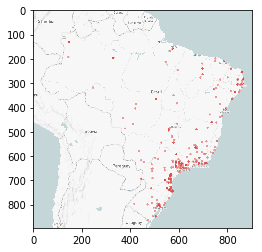

In [28]:
plt.imshow(pointmap)
plt.show();

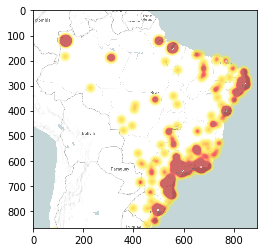

In [29]:
plt.imshow(heatmap)
plt.show();

**Resultado dos grafos após plot no Gephi:**

In [30]:
hashtags = mpimg.imread('hashtags.png')
retweets = mpimg.imread('retweets.png')

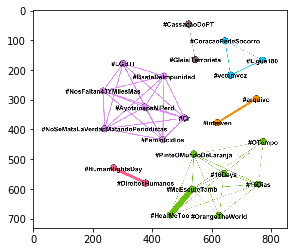

In [31]:
tweets_count = mpimg.imread('tweets_count.png')
plt.imshow(tweets_count)
plt.show();

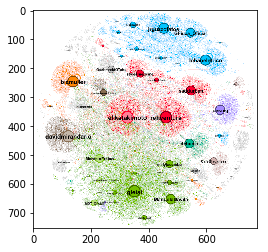

In [32]:
plt.imshow(retweets)
plt.show();

**Considerações finais**:

A partir de algumas funções básicas, foi possível analisar o dataset de cem mil tweets após uma limpeza inicial, em que retiramos as publicações de menor (<25%) e maior (>75%) impacto com base no número de retweets indexado pelo Twitter. Isso pode ser aprimorado, mas permitiu um grafo com menos nós de comportamento de autoridade no resultado final e uma maior legibilidade (projetos finais [disponíveis para download](https://www.dropbox.com/sh/k8wyajd27lo6yke/AADB3ubQrW9uV8fI1SLRbLIha?dl=0)).